# Test workflow in and from within R

In [50]:
getwd()
R.Version()$version.string
# system call function wrapper
s <- function(x, o = T, e = F) {
    redir <- if (e) { "2>&1" } else { "" }
    res <- system(paste(x, redir), intern=TRUE, ignore.stdout = !o)
    if (length(res) > 1) { cat(res, sep='\n') }
}
dd <- function(x) { unlink(x, recursive = T) }
nd <- function(x) {
    unlink(x, recursive = T)
    dir.create(x)
}
library(magrittr)

[1] "/home/clemens/agora/paagen/playground"

[1] "R version 4.0.4 (2021-02-15)"

In [51]:
if (!file.exists("data")) dir.create("data")

In [52]:
s('trident fetch -d data -f "*2012_PattersonGenetics*"')

In [53]:
janno_raw <- poseidonR::read_janno("data/2012_PattersonGenetics")

Validating .janno files...

No issues with these .janno files

Reading .janno files...



In [54]:
colnames(janno_raw)

[1] "source_file"           "Individual_ID"         "Collection_ID"        
 [4] "Source_Tissue"         "Country"               "Location"             
 [7] "Site"                  "Latitude"              "Longitude"            
[10] "Date_C14_Labnr"        "Date_C14_Uncal_BP"     "Date_C14_Uncal_BP_Err"
[13] "Date_BC_AD_Median"     "Date_BC_AD_Start"      "Date_BC_AD_Stop"      
[16] "Date_Type"             "No_of_Libraries"       "Data_Type"            
[19] "Genotype_Ploidy"       "Group_Name"            "Genetic_Sex"          
[22] "Nr_autosomal_SNPs"     "Coverage_1240K"        "MT_Haplogroup"        
[25] "Y_Haplogroup"          "Endogenous"            "UDG"                  
[28] "Library_Built"         "Damage"                "Xcontam"              
[31] "Xcontam_stderr"        "mtContam"              "mtContam_stderr"      
[34] "Primary_Contact"       "Publication_Status"    "Note"                 
[37] "Keywords"

In [55]:
# filtering to sampels with spatial position
janno_filtered <- janno_raw %>% dplyr::filter(
    !is.na(Latitude) & !is.na(Longitude)
)

# Nr_autosomal_SNPs: should be >= 20000 SNPs
janno_QC <- janno_filtered %>% dplyr::filter(
  Nr_autosomal_SNPs >= 20000
)
# Xcontam: if male, then should not be higher then 10%
janno_QC <- janno_QC %>% dplyr::filter(
  is.na(Xcontam) | Genetic_Sex == "F" | (Genetic_Sex == "M" & Xcontam < 0.1)
)
# Genetic_Sex: Individuals with unknown genetic sex should be removed
janno_QC <- janno_QC %>% dplyr::filter(Genetic_Sex != "U")
# Indicated as contaminated: Individuals which are indicated as potentially contaminated
# in their ID should be removed
janno_QC <- janno_QC %>% dplyr::filter(
  !grepl("cont|excluded|Ignore", x = Individual_ID, ignore.case = T) &
    !grepl("cont|excluded|Ignore", x = Group_Name, ignore.case = T)
)

In [56]:
nrow(janno_raw)
nrow(janno_filtered)
nrow(janno_QC)

[1] 1036

[1] 1036

[1] 861

In [87]:
manual_pois <- tibble::tribble(
    ~time, ~lat, ~lon,
    2000, 46, 3,
    2000, 46, 3,
    2000, 46, 3,
    2000, 55, 37    
)

world <- rnaturalearth::ne_countries(scale = "small", returnclass = "sf")

poi_grid <- world %>% 
    dplyr::filter(continent != "Antarctica") %>%
    sf::st_make_grid(cellsize = 20, what = "centers") %>%
    sf::st_sf() %>%
    sf::st_intersection(world) %>%
    dplyr::mutate(
      lon = sf::st_coordinates(.)[,1],
      lat = sf::st_coordinates(.)[,2]
    ) %>%
    sf::st_drop_geometry() %>%
    dplyr::transmute(
      time = 2000,
      lon = round(.data[["lon"]], 3),
      lat = round(.data[["lat"]], 3)
    )

nrow(poi_grid)

poi_string <- purrr::pmap(poi_grid, function(time, lat, lon) {
    paste(time, lat, lon, sep = ",")
}) %>% paste(collapse = ";")

poi_string

although coordinates are longitude/latitude, st_intersection assumes that they are planar

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


[1] 36

[1] "2000,34.388,70;2000,-45.612,-70;2000,-25.612,130;2000,-25.612,150;2000,54.388,30;2000,-25.612,-50;2000,-5.612,-70;2000,-5.612,-50;2000,54.388,-130;2000,54.388,-110;2000,54.388,-90;2000,54.388,-70;2000,-25.612,-70;2000,34.388,90;2000,34.388,110;2000,54.388,10;2000,74.388,-50;2000,74.388,-30;2000,14.388,-90;2000,34.388,50;2000,54.388,70;2000,14.388,-10;2000,14.388,10;2000,-45.612,170;2000,-5.612,150;2000,54.388,50;2000,54.388,90;2000,54.388,110;2000,54.388,130;2000,74.388,90;2000,14.388,30;2000,34.388,10;2000,-5.612,30;2000,34.388,-110;2000,34.388,-90;2000,-25.612,30"

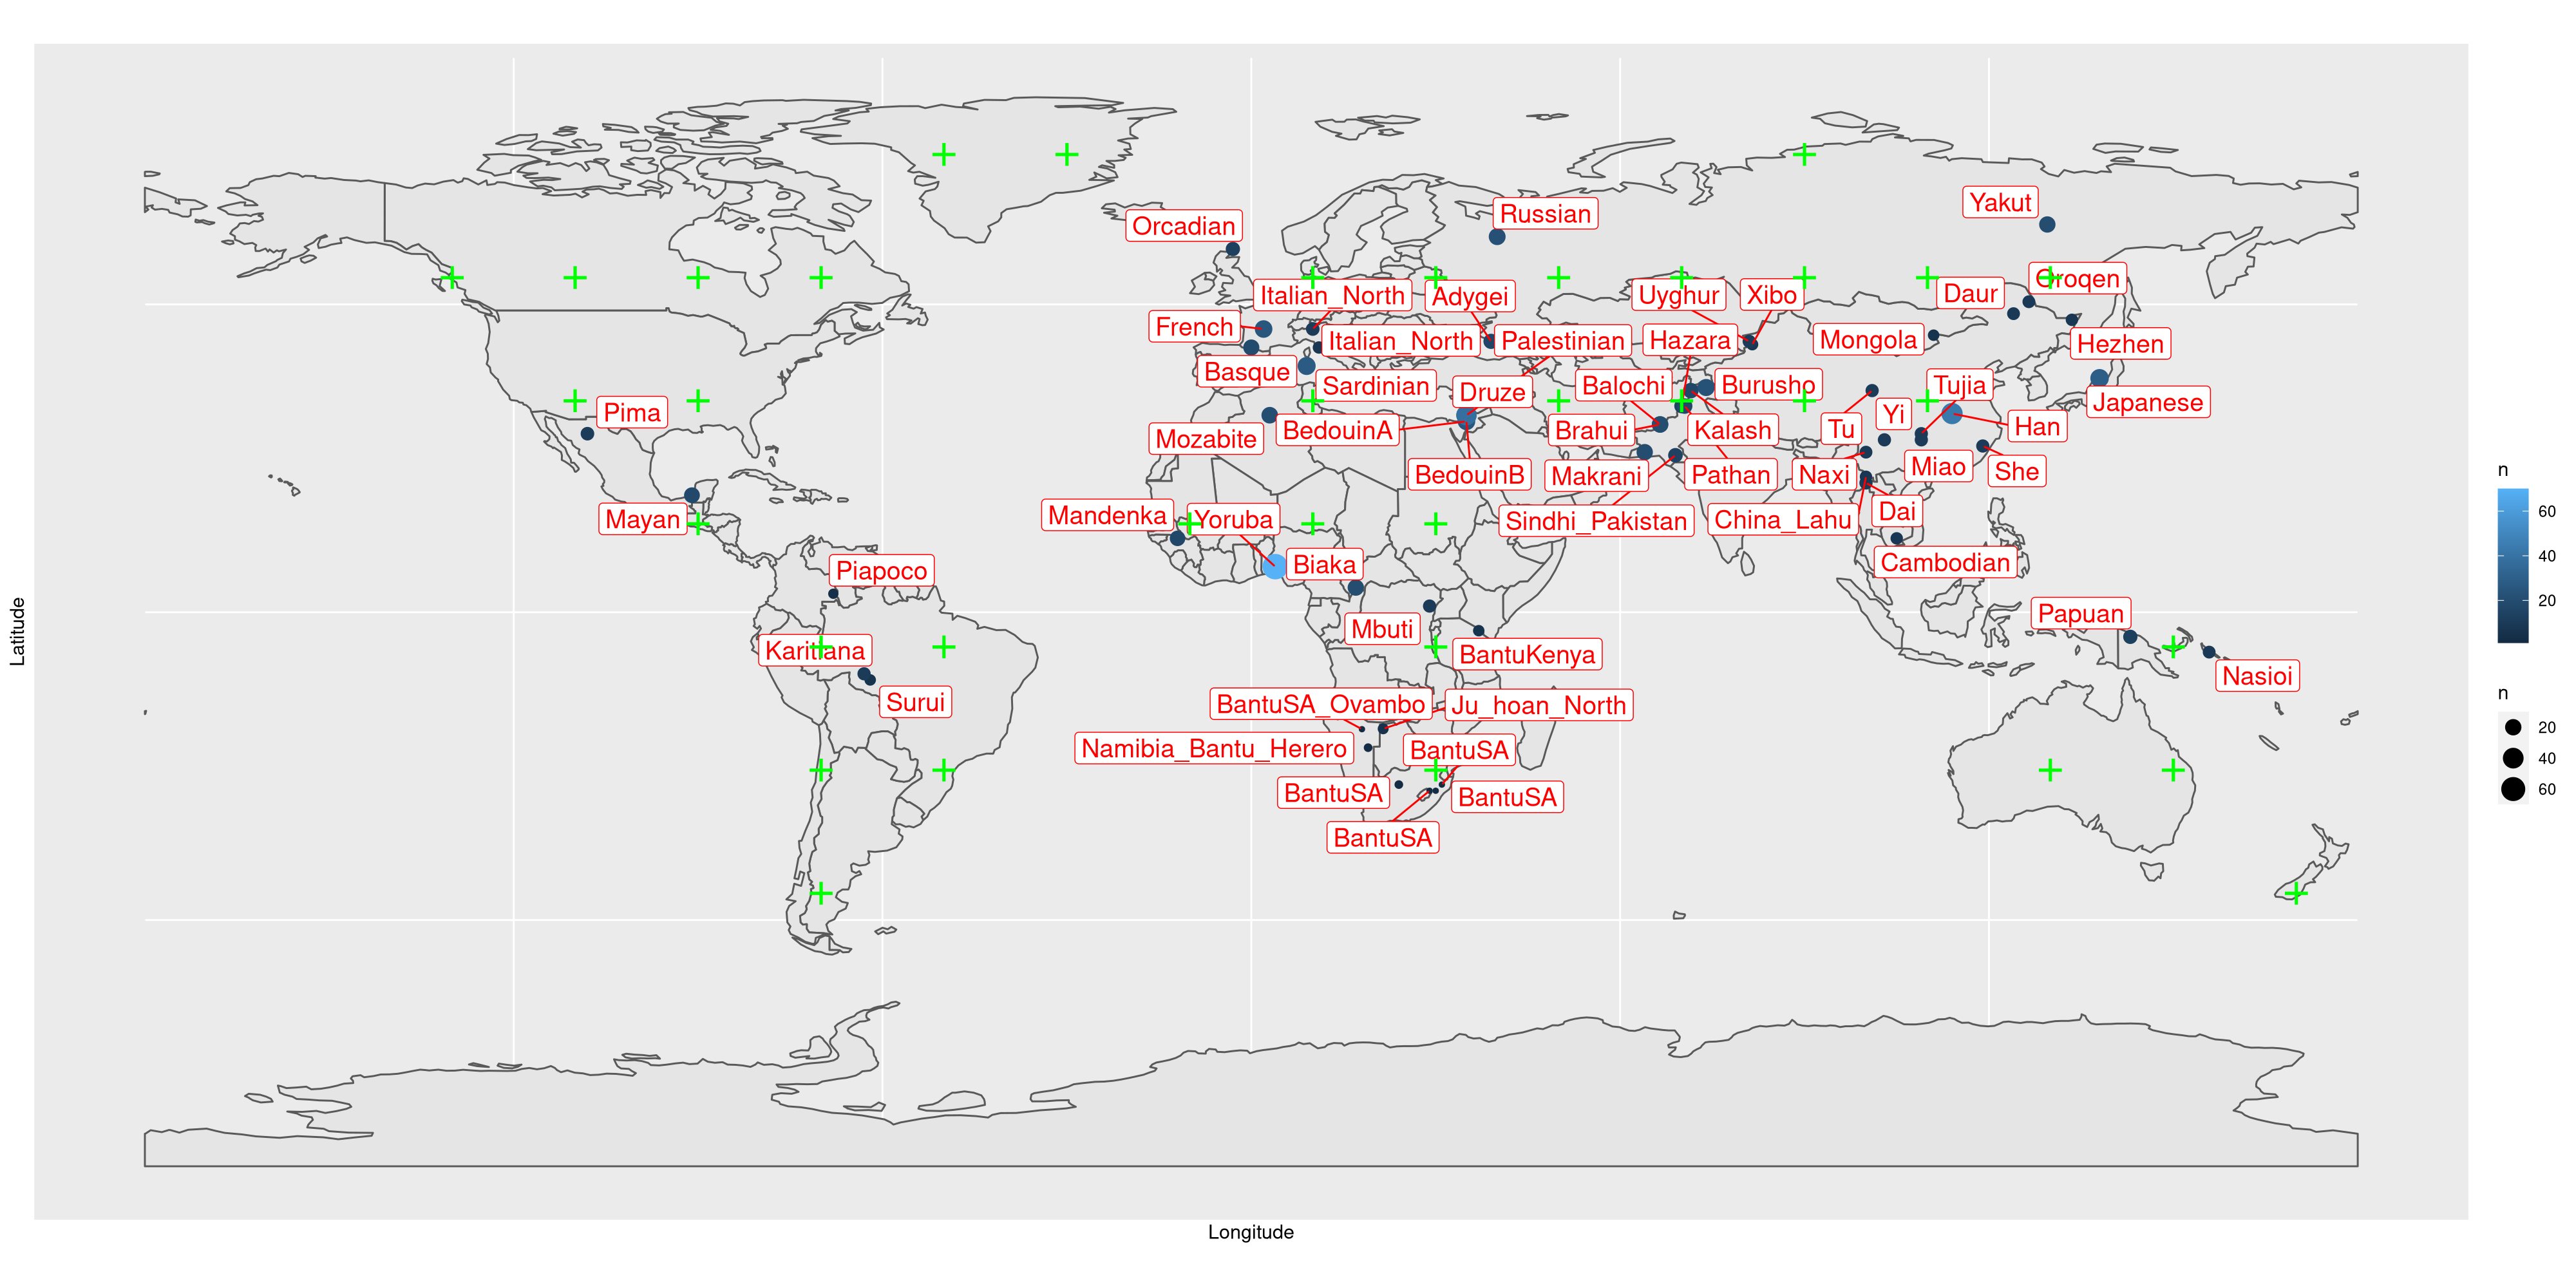

In [120]:
options(repr.plot.width = 20, repr.plot.height = 10, repr.plot.res = 200)

library(ggplot2)

janno_grouped <- janno_QC %>%
dplyr::group_by(Group_Name, Latitude, Longitude) %>%
dplyr::summarise(n = dplyr::n(), .groups = "drop")

ggplot() +
geom_sf(data = world) +
geom_point(data = janno_grouped, aes(x = Longitude, y = Latitude, size = n, color = n)) +
ggrepel::geom_label_repel(
    data = janno_grouped, 
    aes(x = Longitude, y = Latitude, label = Group_Name), 
    color = "red", size = 5, max.overlaps = 100
) +
geom_point(data = poi_grid, aes(x = lon, y = lat), color = "green", size = 9, shape = "+")

In [92]:
# store ind list for poseidon extraction
tibble::tibble(
  #pop = sapply(janno_filtered_final$Group_Name, function(x) { x[[1]] }),
  ind = paste0("<", sort(janno_QC$Individual_ID), ">")
) %>% 
  readr::write_delim(
    file = "data/ind_list.txt",
    delim = " ",
    col_names = FALSE
  )

In [9]:
dd("data/pat")
s('trident forge --forgeFile data/ind_list.txt -d data/2012_PattersonGenetics -n pat -o data/pat')

In [93]:
nd("data/poi")
s(paste0('paagen spacetime -d data/pat -p "', poi_string, '" --neighbors 100 -o data/poi --outFormat EIGENSTRAT'))

In [94]:
dd("data/poi_poseidon")
s('trident init --inFormat EIGENSTRAT --genoFile data/poi/poi.geno --snpFile data/poi/poi.snp --indFile data/poi/poi.ind -o data/poi_poseidon -n poi')

In [95]:
dd("data/merged")
s('trident forge -d data/pat -d data/poi_poseidon -f "*pat*,*poi*" -o data/merged -n merged')

In [96]:
# pruning
nd("data/merged_pruned")
s('plink1.9 --bfile data/merged/merged --exclude data/myrange.txt --range --maf --make-bed --out data/merged_pruned/merged.pruned')

PLINK v1.90p 64-bit (25 Mar 2021)              www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/merged_pruned/merged.pruned.log.
Options in effect:
  --bfile data/merged/merged
  --exclude data/myrange.txt
  --maf
  --make-bed
  --out data/merged_pruned/merged.pruned
  --range

Note: --range flag deprecated.  Use e.g. "--extract range <filename>".
16004 MB RAM detected; reserving 8002 MB for main workspace.
597573 variants loaded from .bim file.
897 people (559 males, 302 females, 36 ambiguous) loaded from .fam.
Ambiguous sex IDs written to data/merged_pruned/merged.pruned.nosex .
--exclude range: 15839 variants excluded.
--exclude range: 581734 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 897 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%1

In [97]:
# generate general pairwise stats
nd("data/merge_pruned_distances")
s('plink1.9 --bfile data/merged_pruned/merged.pruned --genome --out data/merge_pruned_distances/merged.pruned')

PLINK v1.90p 64-bit (25 Mar 2021)              www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/merge_pruned_distances/merged.pruned.log.
Options in effect:
  --bfile data/merged_pruned/merged.pruned
  --genome
  --out data/merge_pruned_distances/merged.pruned

16004 MB RAM detected; reserving 8002 MB for main workspace.
492172 variants loaded from .bim file.
897 people (559 males, 302 females, 36 ambiguous) loaded from .fam.
Ambiguous sex IDs written to data/merge_pruned_distances/merged.pruned.nosex .
Using up to 15 threads (change this with --threads).
Before main variant filters, 897 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%4

In [98]:
# create mds table
nd("data/mds")
s('plink1.9 --bfile data/merged_pruned/merged.pruned --cluster --mds-plot 2 --read-genome data/merge_pruned_distances/merged.pruned.genome --out data/mds/mds')

PLINK v1.90p 64-bit (25 Mar 2021)              www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/mds/mds.log.
Options in effect:
  --bfile data/merged_pruned/merged.pruned
  --cluster
  --mds-plot 2
  --out data/mds/mds
  --read-genome data/merge_pruned_distances/merged.pruned.genome

16004 MB RAM detected; reserving 8002 MB for main workspace.
492172 variants loaded from .bim file.
897 people (559 males, 302 females, 36 ambiguous) loaded from .fam.
Ambiguous sex IDs written to data/mds/mds.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 897 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%

In [99]:
mds <- readr::read_delim(
        "data/mds/mds.mds", " ", trim_ws = T,
        col_types = "ccddd_"
    )

Warning message:
“Missing column names filled in: 'X6' [6]”


In [100]:
mds

FID,IID,SOL,C1,C2
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Brahui,HGDP00001,0,-0.00991120,-0.0401462
Brahui,HGDP00003,0,-0.01134270,-0.0406632
Brahui,HGDP00005,0,-0.01175990,-0.0386182
Brahui,HGDP00007,0,-0.01096050,-0.0420628
Brahui,HGDP00011,0,-0.01251360,-0.0416622
Brahui,HGDP00015,0,-0.01201680,-0.0427612
Brahui,HGDP00017,0,-0.01163410,-0.0417813
Brahui,HGDP00019,0,-0.01214720,-0.0378140
Brahui,HGDP00021,0,-0.00576254,-0.0414307


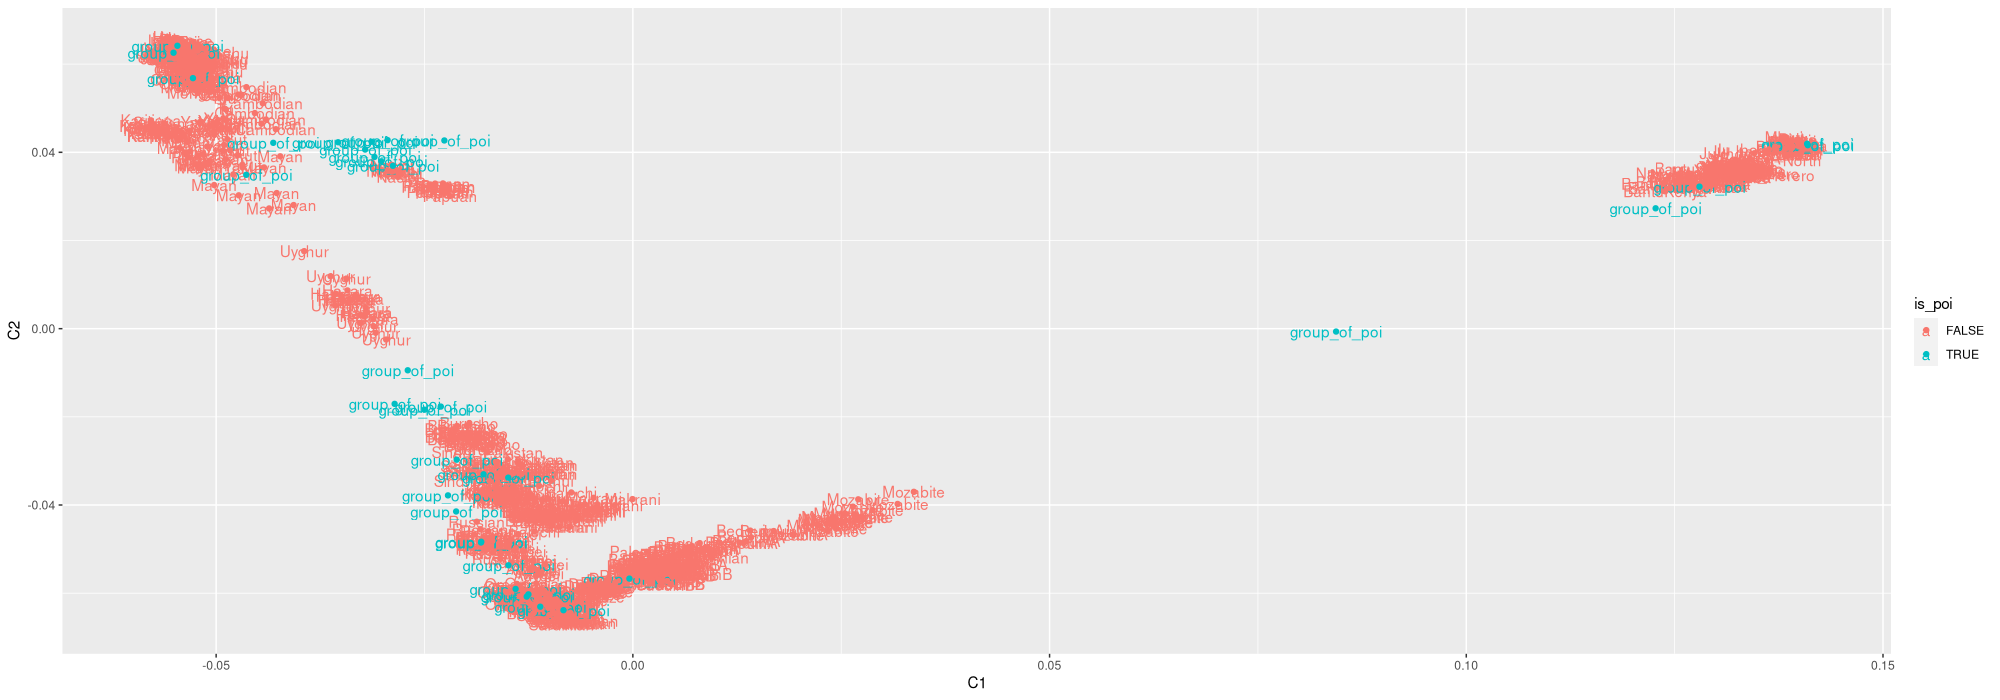

In [101]:
library(ggplot2)
options(repr.plot.width = 20, repr.plot.height = 7, repr.plot.res = 100)

mds %>%
dplyr::mutate(
    is_poi = FID == "group_of_poi"
) %>% 
ggplot() +
geom_text(aes(x = C1, y = C2, color = is_poi, label = FID)) +
geom_point(aes(x = C1, y = C2, color = is_poi))

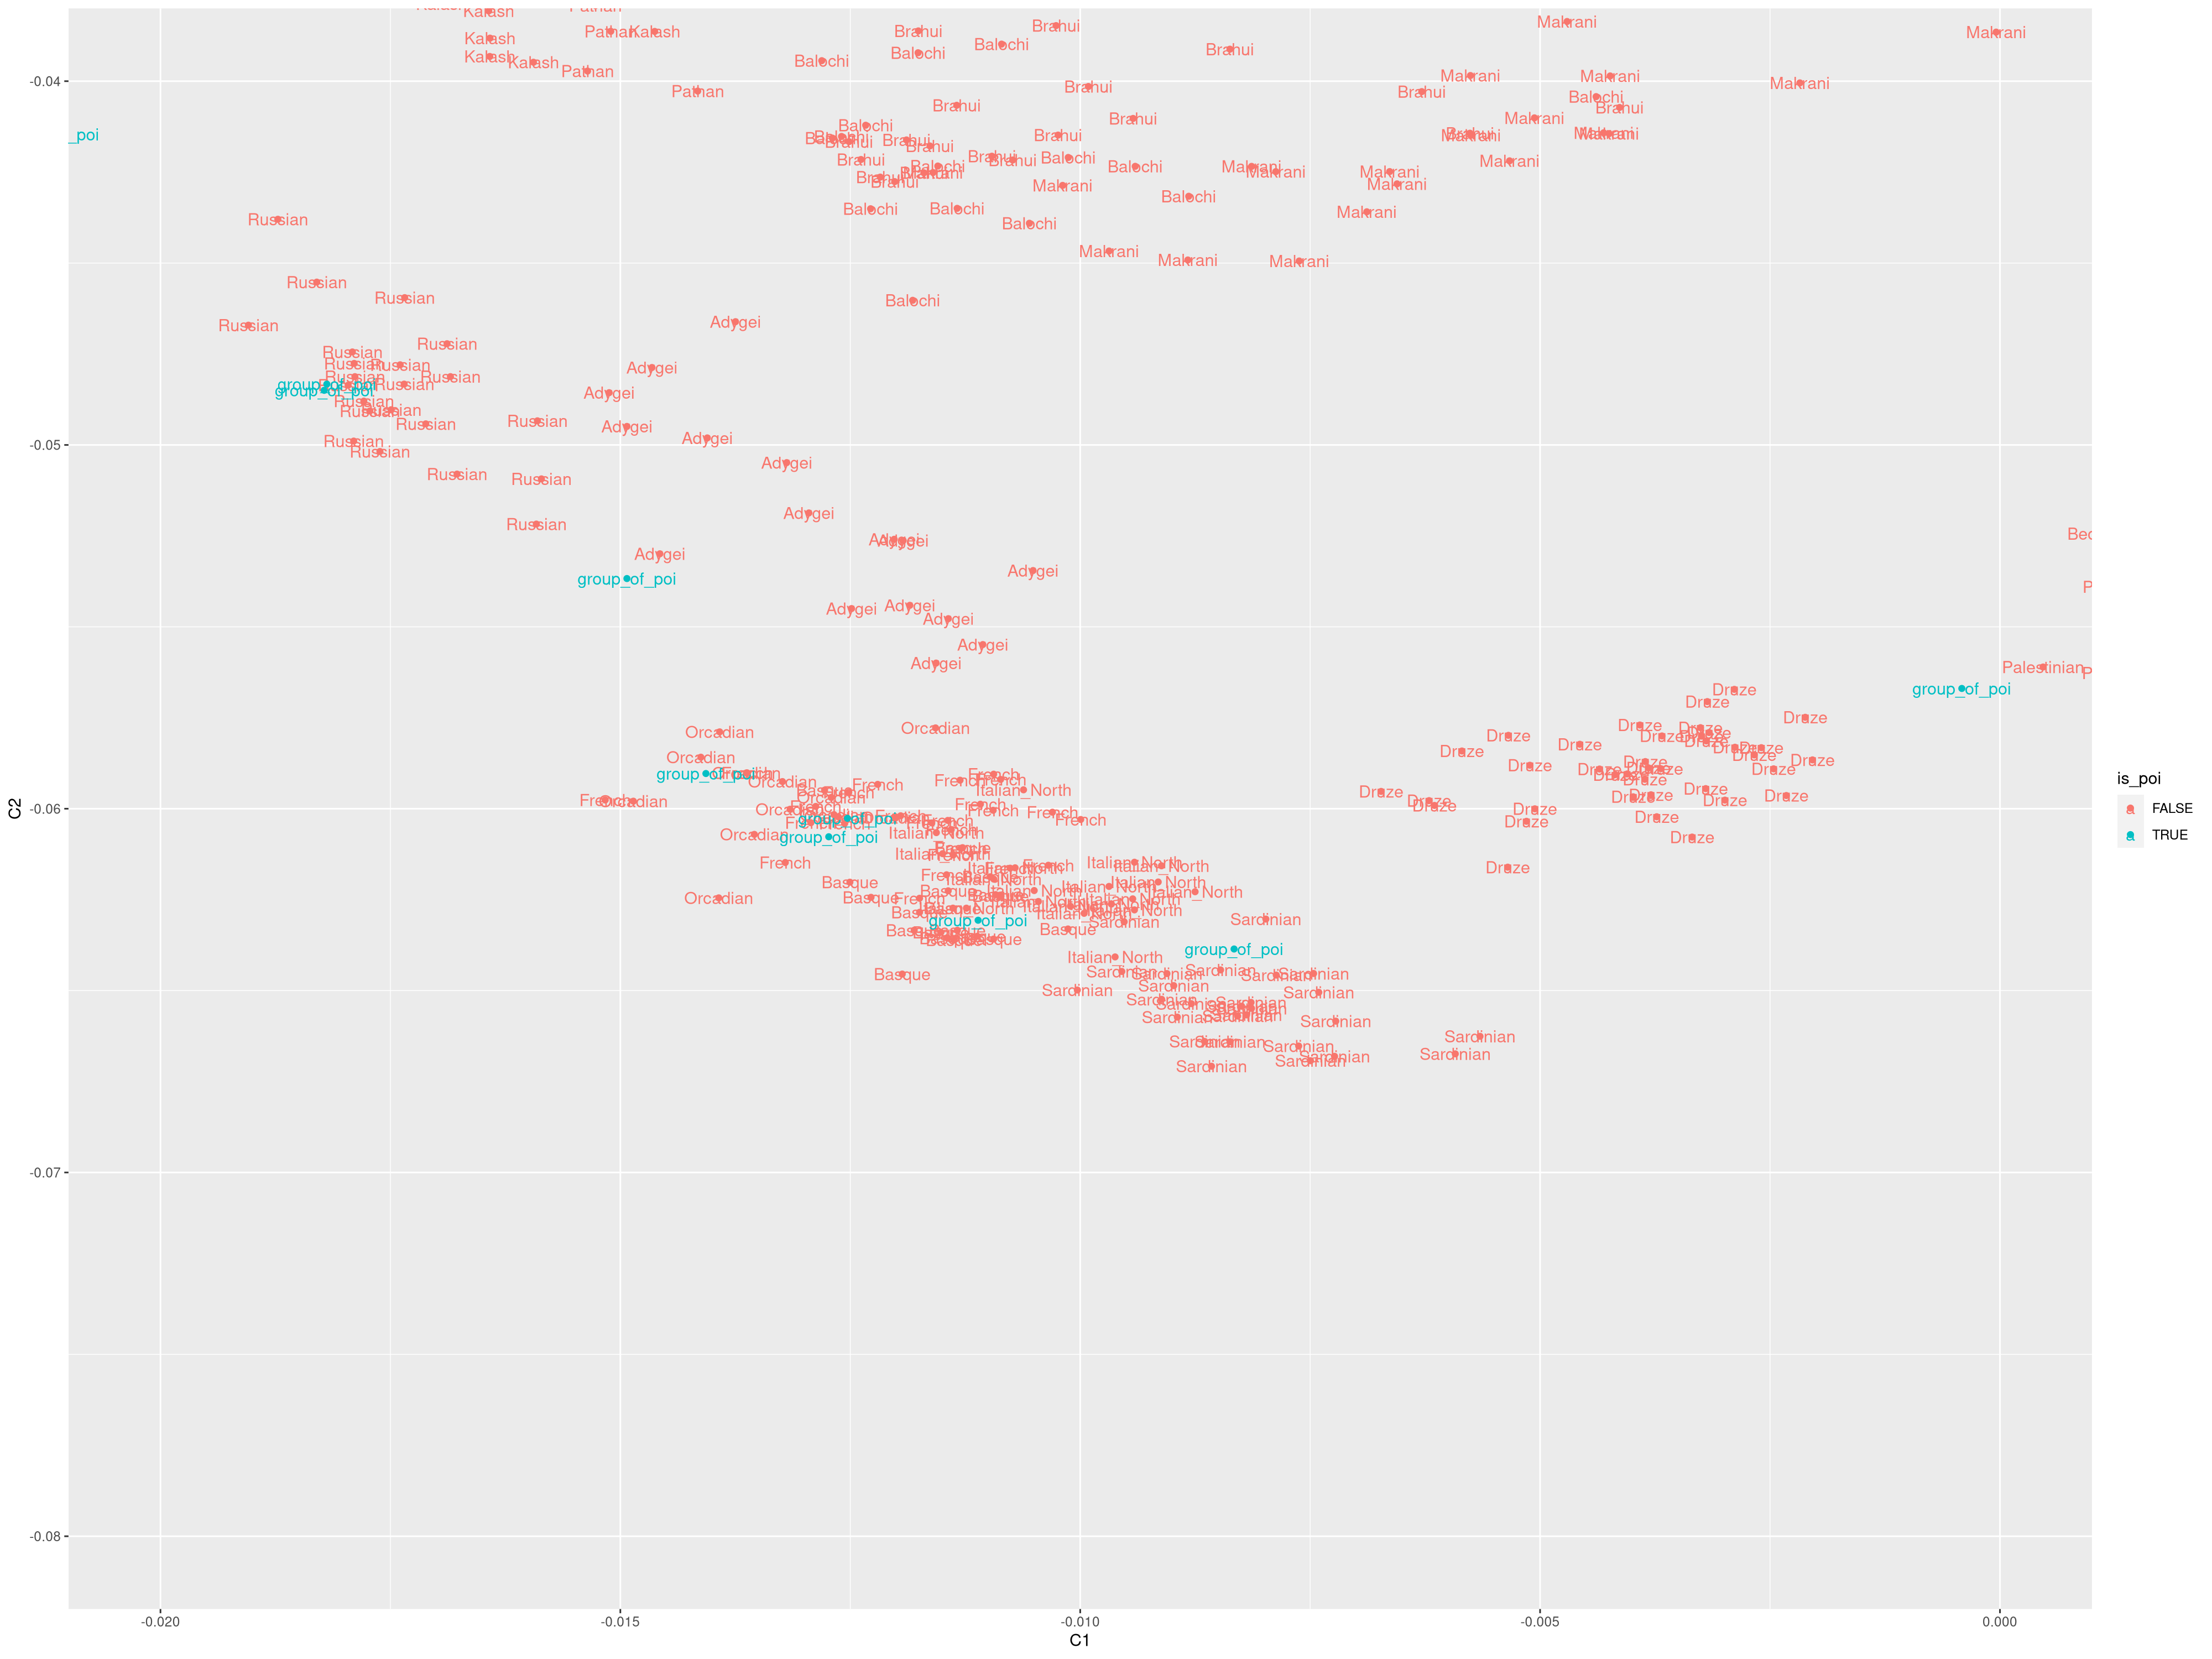

In [102]:
library(ggplot2)
options(repr.plot.width = 20, repr.plot.height = 15, repr.plot.res = 200)

mds %>%
dplyr::mutate(
    is_poi = FID == "group_of_poi"
) %>% 
ggplot() +
geom_text(aes(x = C1, y = C2, color = is_poi, label = FID)) +
geom_point(aes(x = C1, y = C2, color = is_poi)) +
coord_cartesian(xlim = c(-0.02, 0), ylim=c(-0.08,-0.04))